In [ ]:
#Second Attempt at Fine-Tuning a CNN for OCT image Classification.

#This attempt we will fine tune the EfficientNetV2_b0 from hugging face
#This attempt we will use the UCSD Dataset
#This attempt we will apply image pre-processing to enhance the contrast of the ROI
#Edit the training loop and fix any errors

# Fine-Tuning Attempt #2
https://www.frontiersin.org/journals/computer-science/articles/10.3389/fcomp.2023.1252295/full
- Model, https://huggingface.co/timm/tf_efficientnetv2_b0.in1k
- Dataset, https://data.mendeley.com/datasets/rscbjbr9sj.
- Optimizer, Adam
- Loss Function, CrossEntropy
- Pre-Processing, Using OpenCV

1. Load Data
2. Pre-Process (CLAHE Contrast Limited Adaptive Histogram Equalization)
3. DataLoader
4. Visualize Data
3. Load Model
4. Training Loop
5. Evaluation
6. Visualize Predictions

In [ ]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2 as cv
import random
from glob import glob
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
import os
import timm
from timm import create_model
from PIL import Image


In [ ]:
!pip install timm

## Loading Data

In [ ]:
#Loading the data from the UCSD Large Dataset.
!kaggle datasets download -d mmazizi/ucsd-3-class-labeled-retinal-oct-images
!unzip ucsd-3-class-labeled-retinal-oct-images.zip


Streaming output truncated to the last 5000 lines.
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-3.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-4.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-5.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-6.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-7.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-8.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-9.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-1.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-10.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-2.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-3.jpeg  
  inflating: OCTUCSD-3cl

### Visualize Dataset

In [ ]:
#we want a dataframe, reading in datasets with pandas reading the csv
#cvs label classes, 0:Drusen, 1:CNV, 2:Normal
#since ml works better with numbers we label each of the images with 0,1,2
csv_path = "/content/ucsd_train.csv"
df = pd.read_csv(csv_path)
df.head()





,Unnamed: 0.1,Unnamed: 0,file-name,class-id
0,16794,16794,OCT/train/CNV/CNV-1781140-39.jpeg,1
1,60242,60242,OCT/train/NORMAL/NORMAL-4446447-11.jpeg,2
2,74083,74083,OCT/train/NORMAL/NORMAL-4489896-8.jpeg,2
3,62436,62436,OCT/train/NORMAL/NORMAL-1193128-13.jpeg,2
4,88057,88057,OCT/train/NORMAL/NORMAL-7398942-30.jpeg,2


In [ ]:
dataset_path = '/content/OCTUCSD-3class/OCTUCSD-3class/OCT/train'

# Initialize an empty list to store image information
image_data = []

# Loop through each folder in the dataset directory
for label_folder in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label_folder)

    # Check if the current item is a directory (to avoid files in the dataset root)
    if os.path.isdir(label_path):
        # Loop through all images in the current label folder
        for image_file in os.listdir(label_path):
            # Get the full path of the image
            image_path = os.path.join(label_path, image_file)
            # Append the image path and label to the image_data list
            image_data.append([image_path, label_folder])

# Create a DataFrame from the list
df = pd.DataFrame(image_data, columns=['image_path', 'label'])

# Show the first few rows of the DataFrame to verify
print(df.head())

                                          image_path   label
0  /content/OCTUCSD-3class/OCTUCSD-3class/OCT/tra...  NORMAL
1  /content/OCTUCSD-3class/OCTUCSD-3class/OCT/tra...  NORMAL
2  /content/OCTUCSD-3class/OCTUCSD-3class/OCT/tra...  NORMAL
3  /content/OCTUCSD-3class/OCTUCSD-3class/OCT/tra...  NORMAL
4  /content/OCTUCSD-3class/OCTUCSD-3class/OCT/tra...  NORMAL


In [ ]:
# Group by the 'label' column and count the number of images for each label
label_counts = df['label'].value_counts().reset_index()
# Rename the columns for better clarity
label_counts.columns = ['Label', 'Number of Images']
# Display the table
print(label_counts)

    Label  Number of Images
0  NORMAL             51140
1     CNV             37205
2  DRUSEN              8616


> Pytorch datasets and dataloaders, classes in pytorch that help us load and process data for ML problems, need efficient algorithms to load and process data. data loader takes a dataset loaded in and creates batch sizes, shuffles etc. Data is loaded into the dataset class through methods or attributes, this dataset class is then fed into the dataloader, this loads and accesses the data. The dataset class needs to know the length of the dataset.

Text(0.5, 1.0, 'Original')

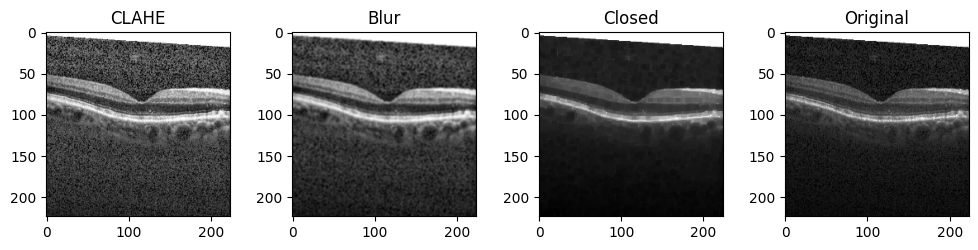

In [ ]:
#View Pre-Processing Techniques


image = cv.imread("/content/OCTUCSD-3class/OCTUCSD-3class/OCT/train/DRUSEN/DRUSEN-1001666-1.jpeg", cv.IMREAD_GRAYSCALE)  # Read grayscale
image = cv.resize(image, (224, 224))          # Resize
# Optionally apply CLAHE
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image_eq = clahe.apply(image)
image_blur = cv.GaussianBlur(image_eq, (3,3), 0)
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
image_closed = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)

#plot image processing techniques, 1,3 figure
fig, ax = plt.subplots( 1,4,figsize = (10,10)) #create visual layout for images, 2x2 grid
fig.tight_layout()          #layout images neatly

ax[0].imshow(image_eq, cmap='gray')
ax[0].set_title('CLAHE')

ax[1].imshow(image_blur, cmap='gray')
ax[1].set_title('Blur')

ax[2].imshow(image_closed, cmap='gray')
ax[2].set_title('Closed')

ax[3].imshow(image, cmap='gray')
ax[3].set_title('Original')





### Read/Transform Dataset

In [ ]:

#we want to use ~8000 of each image for our training, since we want to avoid bias in our model
#training the model on all 51000 normal images would cause bias towards normal.

#loading the training set, split this set into 80, 20 train, validation sets
#note x are features and y is the outcome
#x=image, y=label


#Read and process images, CLAHE and Gaussian Blur processsing using openCV
def read_process_images(path, image_size = (224,224) ):
  image = cv.imread(path, cv.IMREAD_GRAYSCALE)  # Read grayscale
  image = cv.resize(image, image_size)          # Resize
  # Optionally apply CLAHE, and Gaussian Blur
  clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  image = clahe.apply(image)
  image = cv.GaussianBlur(image, (5,5), 0)
  #normalize intensity range. 0-1
  image = image / 255.0
  return image

#sample the image sets 8600 of each class to avoid bias
def sample_images(file_path, sample_size):
  img_path = os.path.join(file_path, "*.jpeg")
  images = glob(img_path)
  sample_set = random.sample(images, sample_size)
  #list comprehension, get processing images for each image in sample set, return a list of these processing imgs
  return [read_process_images(img_path) for img_path in sample_set]


In [ ]:
train_path = "/content/OCTUCSD-3class/OCTUCSD-3class/OCT/train"
test_path = "/content/OCTUCSD-3class/OCTUCSD-3class/OCT/test"
image_size = (224,224)
train_size = 8000



norm_imgs = sample_images(os.path.join(train_path, "NORMAL"), train_size)
cnv_imgs = sample_images(os.path.join(train_path, "CNV"), train_size)
drusen_imgs = sample_images(os.path.join(train_path, "DRUSEN"), train_size)

#create image and label sets for dataloader
image_data = norm_imgs + cnv_imgs + drusen_imgs
labels = [0] * len(norm_imgs) + [1] * len(cnv_imgs) + [2] * len(drusen_imgs)



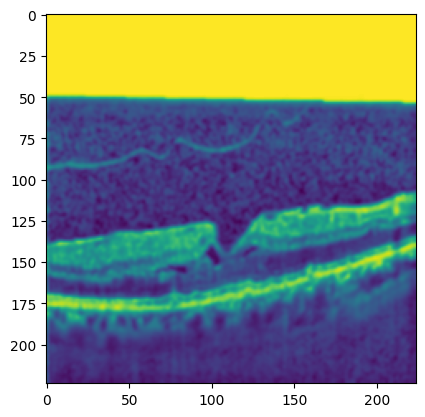

In [ ]:
plt.imshow(drusen_imgs[1])

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
# Define the custom Dataset class
class OCTDataset(Dataset):
    def __init__(self, folder_paths, sample_size, image_size=(224, 224), transform=None):
        self.image_paths = []

        # Sample images from each class
        for path in folder_paths:
            images = glob(os.path.join(path, "*.jpeg"))
            sampled_images = random.sample(images, sample_size)
            self.image_paths.extend(sampled_images)

        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # Read, resize, and pre-process image
        # Load and resize image with OpenCV
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv.resize(img, self.image_size)  # Resize to desired size (224, 224)

        # Convert image to tensor
        img = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0  # Normalize to [0,1]

        if self.transform:
            img = self.transform(img)  # Apply additional transforms
        label = self.get_label_from_path(img_path)

        return img, label

    def get_label_from_path(self, path):
        if "NORMAL" in path:
            return 0
        elif "CNV" in path:
            return 1
        elif "DRUSEN" in path:
            return 2

# Define the dataset paths and initialize the Dataset and DataLoader
train_path = "/content/OCTUCSD-3class/OCTUCSD-3class/OCT/train"
folder_paths = [
    os.path.join(train_path, "NORMAL"),
    os.path.join(train_path, "CNV"),
    os.path.join(train_path, "DRUSEN")
]


sample_size = 4000  # Specify the number of images to sample from each class
# Create the dataset and data loader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Make grayscale images 3-channel
    transforms.Resize((224, 224)),                # Resize to 224x224
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
full_dataset = OCTDataset(folder_paths, sample_size)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


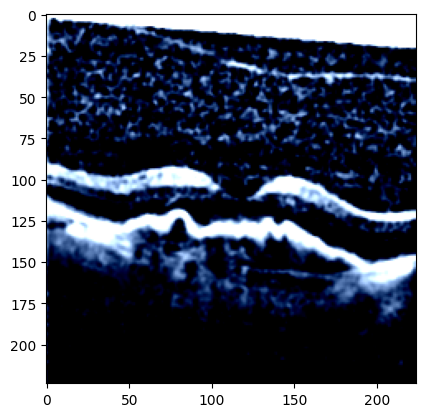

Label: 1
Tyoe: <class 'numpy.ndarray'>


In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Visualize one of the images in the batch
img = train_features[0].squeeze().permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {train_labels[0]}")
print(f"Tyoe: {type(img)}")

## Training Loop

In [ ]:
from tqdm import tqdm

# Training loop function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cuda"):
    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions.double() / len(train_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        correct_val_predictions = 0

        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val_predictions += torch.sum(preds == labels)

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_val_predictions.double() / len(val_loader.dataset)

        print(f"Validation Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")

    print("Training complete")
    return model

In [ ]:


# Load the EfficientNetV2-B0 model with pre-trained weights
model = timm.create_model("tf_efficientnetv2_b0", pretrained=True)

# Modify the final layer to match the number of classes (3 in this case)
num_classes = 3
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam

# Set up the optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Assume train_loader and val_loader are defined as before
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 5

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


Epoch 1/5
----------


100%|██████████| 300/300 [32:29<00:00,  6.50s/it]

Train Loss: 0.2461 Acc: 0.9134


Validation Loss: 0.1631 Acc: 0.9442
Epoch 2/5
----------


100%|██████████| 300/300 [32:54<00:00,  6.58s/it]

Train Loss: 0.1332 Acc: 0.9559


Validation Loss: 0.1515 Acc: 0.9529
Epoch 3/5
----------


100%|██████████| 300/300 [32:31<00:00,  6.50s/it]

Train Loss: 0.0919 Acc: 0.9680


Validation Loss: 0.1708 Acc: 0.9467
Epoch 4/5
----------


100%|██████████| 300/300 [32:46<00:00,  6.56s/it]

Train Loss: 0.0661 Acc: 0.9783


Validation Loss: 0.2038 Acc: 0.9317
Epoch 5/5
----------


100%|██████████| 300/300 [32:39<00:00,  6.53s/it]

Train Loss: 0.0783 Acc: 0.9720


Validation Loss: 0.2206 Acc: 0.9396
Training complete


In [ ]:

import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch of images and labels
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Plot the images with predictions
    fig = plt.figure(figsize=(12, 8))
    for idx in range(min(8, len(images))):  # Display up to 8 images
        ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
        img = images[idx].cpu().numpy().transpose((1, 2, 0))  # Convert tensor to NumPy
        plt.imshow(img)
        ax.set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[preds[idx]]}")
    plt.show()




In [ ]:
  #test_dataloader
# Define the custom Dataset class
class OCTDataset(Dataset):
    def __init__(self, folder_paths, sample_size, image_size=(224, 224), transform=None):
        self.image_paths = []

        # Sample images from each class
        for path in folder_paths:
            images = glob(os.path.join(path, "*.jpeg"))
            sampled_images = random.sample(images, sample_size)
            self.image_paths.extend(sampled_images)

        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # Read, resize, and pre-process image
        # Load and resize image with OpenCV
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv.resize(img, self.image_size)  # Resize to desired size (224, 224)

        # Convert image to tensor
        img = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0  # Normalize to [0,1]
        if self.transform:
            img = self.transform(img)  # Apply additional transforms
        label = self.get_label_from_path(img_path)

        return img, label

    def get_label_from_path(self, path):
        if "NORMAL" in path:
            return 0
        elif "CNV" in path:
            return 1
        elif "DRUSEN" in path:
            return 2

# Define the dataset paths and initialize the Dataset and DataLoader
test_path = "/content/OCTUCSD-3class/OCTUCSD-3class/OCT/test"
folder_paths = [
    os.path.join(test_path, "NORMAL"),
    os.path.join(test_path, "CNV"),
    os.path.join(test_path, "DRUSEN")
]

# Create the dataset and data loader
transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize to 224x224
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

sample_size = 100

test_dataset = OCTDataset(folder_paths, sample_size)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

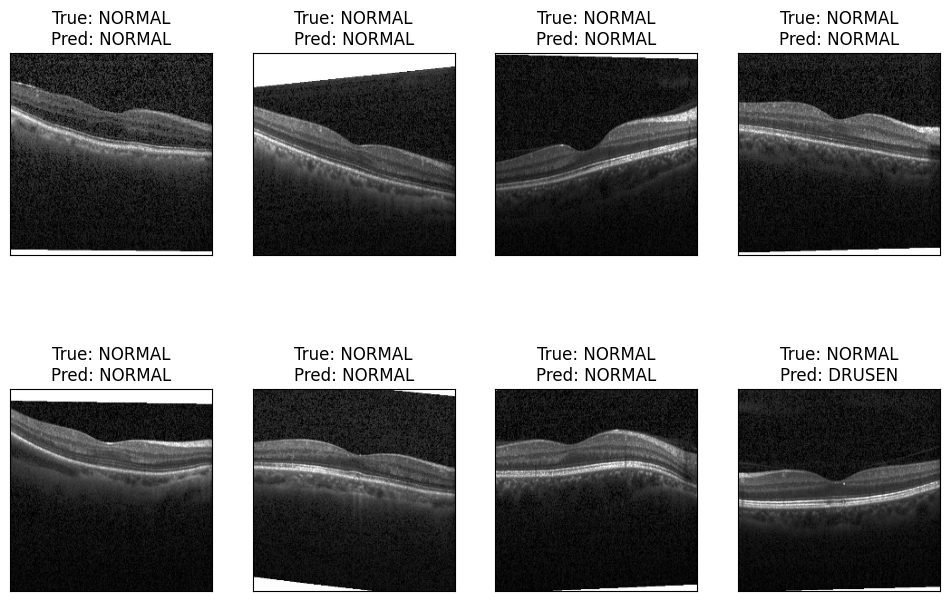

In [ ]:

#Get a variety of predictions from our model,
#test batch of 2cnv 2normal and 2drusen





#I need to get the test dataloader and a class names
class_names = ["NORMAL", "CNV", "DRUSEN"]
visualize_predictions(trained_model, test_dataloader, class_names, device)